In [24]:
__nbid__ = '0075'
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '20250729' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['gnirs','gemini','star','dragons']

# Gemini L-band Longslit Point Source reduction using DRAGONS Python API
***
## Public archival data from GN-2017B-Q-81 (HD41335)
#### adapted from https://gnirsls-drtutorial.readthedocs.io/en/v4.0.0/ex3_gnirsls_Lband10mm_api.html
***

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Prepare the working directory](#Prepare)
* [About the dataset](#About)
* [Downloading data for reduction](#Downloading_Data)
* [Set up the DRAGONS logger](#DRAGONS_logger)
* [Bad Pixel Mask](#BPM)
* [Create Master Flat Field](#Master_Flat)
* [Processed Arc - Wavelength Solution](#Arc)
* [Telluric Standard](#Telluric)
* [Science Observations](#Science)
* [Display 1D Spectrum](#Display)


<a class="anchor" id="goals"></a>
# Goals
Showcase how to reduce GNIRS L-band Longslit point source data using the Gemini DRAGONS package on the Data Lab science platform using a custom DRAGONS kernel `"DRAGONS-4.0.0 (DL,Py3.12)"`. The steps include downloading data from the Gemini archive, setting up a DRAGONS calibration service, processing flats, darks, a bad pixel mask, and science frames, and displaying the reduced 1D spectrum. 

<a class="anchor" id="summary"></a>
# Summary
DRAGONS is a Python-based astronomical data reduction platform written by the Gemini Science User Support Department. It can currently be used to reduce imaging data from Gemini instruments GMOS, NIRI, Flamingos 2, GSAOI, and GNIRS, as well as spectroscopic data taken with GNIRS, GHOST, and GMOS in longslit mode. Linked <a href="https://gnirsls-drtutorial.readthedocs.io/en/v4.0.0/index.html">here</a> is a general list of guides, manuals, and tutorials about the use of DRAGONS.

The DRAGONS kernel has been made available in the Data Lab environment, allowing users to access the routines without being dependent on installing the software on their local machines. 

In this notebook, we present an example of a DRAGONS Jupyter notebook that works in the Data Lab environment to reduce example Gemini North GNIRS L-band data. This notebook will not present all the details of the many options available to adjust or optimize the DRAGONS GNIRS data reduction process, including the interactive features; rather, it will just show one example of a standard reduction. 

The data used in this notebook example is GNIRS L-band Longslit Point Source spectroscopy from the Gemini archive of the Be-star HD41335 from the Gemini North program  "<a href="https://archive.gemini.edu/programinfo/GN-2017B-Q-81">Structure and physical properties of circumestellar envelopes of Be stars</a>", PI: Yanina Cochetti, program ID GN-2017B-Q-81. 

<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
## Disclaimers
Note that using the Astro Data Lab constitutes your agreement with our minimal <a href="https://datalab.noirlab.edu/about/disclaimers">Disclaimers</a>.

## Acknowledgments
If you use Astro Data Lab in your published research, please include the text in your paper's Acknowledgments section:

This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation.

If you use SPARCL jointly with the Astro Data Lab platform (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation.

In either case please cite the following papers:

Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097
If publishing in a AAS journal, also add the keyword: \facility{Astro Data Lab}

And if you are using SPARCL, please also add \software{SPARCL} and cite:

Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024 https://doi.org/10.48550/arXiv.2401.05576
The NOIRLab Library maintains lists of proper acknowledgments to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="imports"></a>
# Importing python libraries

In [25]:
import warnings
import glob
import os
import numpy as np
import astrodata
import shutil
import matplotlib.pyplot as plt

import gemini_instruments
from gempy.adlibrary import plotting
from gempy.utils import logutils
from gempy.adlibrary import dataselect

from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce

from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore")

<a class="anchor" id="Prepare"></a>
# Prepare the working directory

If you have any intermediate files that were created from running this code in the past, you will need to remove them from your working directory. The cell below defines a clean-up function that will remove all the fits files from your working directory. This function will be called again at the end of the tutorial, leaving you with only the final product. By default, this function will delete all files in the working directory. If there are files that have been previously reduced that you would like to keep, set `save_reduced=1` when calling the function.

In [44]:
def clean_up(save_reduced=0):
    #Do the calibrations and raw directories already exist?
    caldb_Exist = os.path.exists('./calibrations') 
    raw_Exist = os.path.exists('./raw')
    
    if caldb_Exist:
        shutil.rmtree('./calibrations', ignore_errors=True)

    if raw_Exist:
        shutil.rmtree('./raw', ignore_errors=True)
        os.mkdir("./raw") 

    #Remove existing log and list files.
    work_dir_path = os.getcwd()
    work_dir = os.listdir(work_dir_path)

    for item in work_dir:
        if item.endswith(".log") or item.endswith(".list") or item.endswith(".lis"):
            os.remove(os.path.join(work_dir_path, item))
    
    #Next, we will remove all the existing fits files, except for the previously reduced files, depending on what you set save_reduced to.
    if save_reduced:
        all_files_0 = glob.glob('*.fits')
        save = dataselect.select_data(all_files_0, [], ['PROCESSED'])
        
        for s in save:
            os.remove(os.path.join(work_dir_path,s))

    else:
        all_files_0 = glob.glob('*.fits')
        for a in all_files_0:
            os.remove(os.path.join(work_dir_path,a))

        #This notebook's final output includes a PDF and dat files. So if you set save_reduced=0, we need to remove these files as well.
        for item in work_dir:
            if item.endswith(".pdf") or item.endswith(".dat"):
                os.remove(os.path.join(work_dir_path, item))

In [45]:
clean_up(save_reduced=0)

<a class="anchor" id="About"></a>
# About the dataset

The data is a GNIRS L-band longslit observation of HD41335. The observation program utilized a 10 l/mm grating with the long-red camera and a 0.1 arcsec slit, centered at 3.7 μm.

The calibrations we use for this example are:
- BPM. The bad pixel masks are now found in the Gemini Science Archive instead of being packaged with the software. They are associated like the other calibrations. (The date in the name is the “valid from” date.)
- Flats taken in the same configuration as the science. They were obtained at night right after the science observations.
- Arcs. No arcs are obtained for L-band data. The wavelength calibration is done using the sky lines in the science observation.
- A telluric standard observation taken in the same configuration as the science and obtained at night, in this case, just before the science observation sequence, and at a similar airmass.

| Observation Type | File name(s) |
| :--- | :--- |
| Science | N20180114S0121-124 |
| Science Flats | N20180114S0125-132 |
| Telluric | N20180114S0113-116 |
| BPM | bpm_20121101_gnirs_gnirsn_11_full_1amp.fits |

<a class="anchor" id="Downloading_Data"></a>
# Downloading the data

Downloading longslit data from the Gemini archive to the raw/ directory. This step only needs to be executed once.

If you run this notebook for the first time and need to download the dataset, set the variable "download=True". The notebook will not redownload the dataset if it is set to False. This will become particularly useful if you run the notebooks more than once. 

In [28]:
%%bash 

# Create a list of FITS files to be downloaded.
echo "\
https://archive.gemini.edu/file/N20180114S0121.fits
https://archive.gemini.edu/file/N20180114S0122.fits
https://archive.gemini.edu/file/N20180114S0123.fits
https://archive.gemini.edu/file/N20180114S0124.fits
https://archive.gemini.edu/file/N20180114S0125.fits
https://archive.gemini.edu/file/N20180114S0126.fits
https://archive.gemini.edu/file/N20180114S0127.fits
https://archive.gemini.edu/file/N20180114S0128.fits
https://archive.gemini.edu/file/N20180114S0129.fits
https://archive.gemini.edu/file/N20180114S0130.fits
https://archive.gemini.edu/file/N20180114S0131.fits
https://archive.gemini.edu/file/N20180114S0132.fits
https://archive.gemini.edu/file/N20180114S0113.fits
https://archive.gemini.edu/file/N20180114S0114.fits
https://archive.gemini.edu/file/N20180114S0115.fits
https://archive.gemini.edu/file/N20180114S0116.fits
https://archive.gemini.edu/file/bpm_20121101_gnirs_gnirsn_11_full_1amp.fits
" > gnirs_Lband.list

In [29]:
%%bash

download="True"

if [ $download == "True" ]; then
    wget --no-check-certificate -N -q -P './raw' -i gnirs_Lband.list

else
    echo "Skipping download. To download the data set used in this notebook, set download=True."
fi

<a class="anchor" id="DRAGONS_logger"></a>
# Setting up the DRAGONS logger

DRAGONS comes with a local calibration manager that uses the same calibration association rules as the Gemini Observatory Archive. This allows reduce to make requests to a local light-weight database for matching processed calibrations when needed to reduce a dataset.

This tells the system where to put the calibration database. This database will keep track of the processed calibrations we will send to it.

In [30]:
logutils.config(file_name='gnirs_ex3_tutorial.log')

caldb = cal_service.set_local_database()
caldb.init("w")

Create a list of all the FITS files in the directory

In [31]:
all_files = glob.glob('raw/*.fits')
print(all_files)

['raw/N20180114S0121.fits', 'raw/N20180114S0122.fits', 'raw/N20180114S0123.fits', 'raw/N20180114S0124.fits', 'raw/N20180114S0125.fits', 'raw/N20180114S0126.fits', 'raw/N20180114S0127.fits', 'raw/N20180114S0128.fits', 'raw/N20180114S0129.fits', 'raw/N20180114S0130.fits', 'raw/N20180114S0131.fits', 'raw/N20180114S0132.fits', 'raw/N20180114S0113.fits', 'raw/N20180114S0114.fits', 'raw/N20180114S0115.fits', 'raw/N20180114S0116.fits', 'raw/bpm_20121101_gnirs_gnirsn_11_full_1amp.fits']


## **A list for the flats**

The flats will need to be stacked together, so use the dataselect to identify the flat files that are compatible with each other.

In [32]:
flats = dataselect.select_data(all_files, ['FLAT'])

## **A list for the tellurics**

Currently, DRAGONS does not have a way to differentiate telluric stars from the rest of the data. This is because GNIRS headers do not contain tags that specifically identify tellurics. In most instances, specifying the "observation_class" descriptor and rejecting files with the "CAL" tag are sufficient to distinguish between tellurics and science observations. 

In [33]:
tellurics = dataselect.select_data(
    all_files,
    [],
    ['CAL'],
    dataselect.expr_parser('observation_class=="partnerCal"')
)

## **A list for the science**

To create a list for the science observations, we will have dataselect pick files with the observation class 'science'. Note: In this example, all the science observations are of a single target. If the observation program had multiple targets, they would need to be split up into their own lists. 

In [34]:
scitarget = dataselect.select_data(
    all_files,
    [],
    ['CAL'],
    dataselect.expr_parser('observation_class=="science" and object=="HD41335"')
)

<a class="anchor" id="BPM"></a>
## **Bad pixel mask**

Starting with DRAGONS v3.1, the static bad pixel masks (BPMs) are now handled as calibrations. They are downloadable from the archive instead of being packaged with the software. They are automatically associated like any other calibrations. This means that the user now must download the BPMs along with the other calibrations and add the BPMs to the local calibration manager.

In [35]:
for bpm in dataselect.select_data(all_files, ['BPM']):
    caldb.add_cal(bpm)

<a class="anchor" id="Master_Flat"></a>
# Create master flat field

GNIRS longslit flat fields are normally obtained at night along with the observation sequence to match the telescope and instrument flexure. The GNIRS longslit flatfield requires only lamp-on flats. Subtracting darks only increases the noise.

The flats will be stacked.

In [36]:
reduce_flats = Reduce()
reduce_flats.files.extend(flats)
reduce_flats.runr()

All submitted files appear valid:
raw/N20180114S0125.fits ... raw/N20180114S0132.fits, 8 files submitted.
RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ---------------------

<a class="anchor" id="Arc"></a>
# Processed arc - wavelength solution
The wavelength solution for L-band data is derived from the wavelengths of strong peaks in the emission spectrum of the sky. The quality of the wavelength solution depends on the width and strength of the telluric features.

In [37]:
reduce_sky = Reduce()
reduce_sky.files.extend(scitarget)
reduce_sky.recipename = 'makeWavecalFromSkyEmission'
reduce_sky.uparms = dict([('interactive', False)])
reduce_sky.runr()

All submitted files appear valid:
raw/N20180114S0121.fits ... raw/N20180114S0124.fits, 4 files submitted.
RECIPE: makeWavecalFromSkyEmission
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GNIRS
      

<a class="anchor" id="Telluric"></a>
# Telluric Standard

The telluric standard observed before the science observation is “hip 28910”. The spectral type of the star is A0V.

To properly calculate and fit a telluric model to the star, we need to know its effective temperature. To properly scale the sensitivity function (to use the star as a spectrophotometric standard), we need to know the star’s magnitude. Those are inputs to the fitTelluric primitive.

The default effective temperature of 9650 K is typical of an A0V star, which is the most common spectral type used as a telluric standard. Different sources give values between 9500 K and 9750 K and, for example, Eric Mamajek’s list “A Modern Mean Dwarf Stellar Color and Effective Temperature Sequence” (https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt) quotes the effective temperature of an A0V star as 9700 K. The precise value has only a small effect on the derived sensitivity and even less effect on the telluric correction, so the temperature from any reliable source can be used. Using Simbad, we find that the star has a magnitude of K=4.523, which is the closest waveband to our observation.

Note that the data are recognized by Astrodata as normal GNIRS longslit science spectra. To calculate the telluric correction, we need to specify the telluric recipe (reduceTelluric), otherwise the default science reduction will be run.

In [38]:
reduce_telluric = Reduce()
reduce_telluric.files.extend(tellurics)
reduce_telluric.recipename = 'reduceTelluric'
reduce_telluric.uparms = dict([
            ('fitTelluric:bbtemp', 9700),
            ('fitTelluric:magnitude', 'K=4.523'),
            ('fitTelluric:interactive', False),
            ])
reduce_telluric.runr()

All submitted files appear valid:
raw/N20180114S0113.fits ... raw/N20180114S0116.fits, 4 files submitted.
RECIPE: reduceTelluric
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GNIRS
         Updating 

<a class="anchor" id="Science"></a>
# Science Observations

The science target, HD41335, is a Be-star. The observation sequence is one ABBA dither pattern. DRAGONS will flatfield, wavelength calibrate, subtract the sky, stack the aligned spectra, extract the source, remove telluric features and flux calibrate.

With all the calibrations in the local calibration manager, you only need to run the following cell to reduce the science observations and extract the 1-D spectrum.

When this cell is done running, a new file will be created called N20180114S0121_1D.fits.

In [39]:
reduce_science = Reduce()
reduce_science.files.extend(scitarget)
reduce_science.runr()

All submitted files appear valid:
raw/N20180114S0121.fits ... raw/N20180114S0124.fits, 4 files submitted.
RECIPE: reduceScience
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GNIRS
         Updating k

<a class="anchor" id="Display"></a>
# Display 1D Spectrum

Finally, you can use astrodata to display the reduced spectrum.

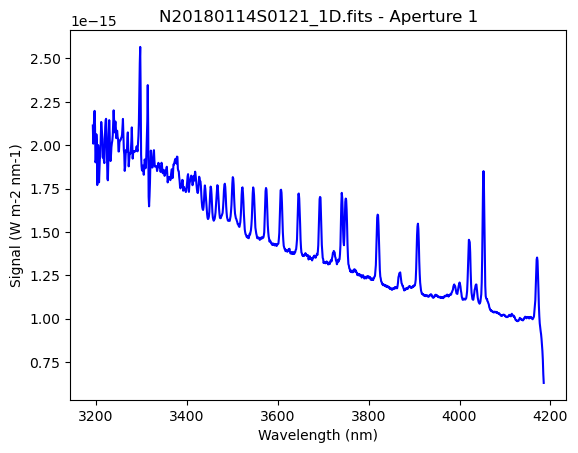

In [40]:
ad = astrodata.open(reduce_science.output_filenames[0])
plotting.dgsplot_matplotlib(ad, 1)

## Optional: Clean up working directory. (uncomment before running)

In [41]:
#clean_up(save_reduced=0)